In [124]:
import gurobipy as gp
import numpy as np
from flight_optimizer import *
import itertools

In [125]:
problem = FlightProblem.from_file("./data/d=0.5/p=10/h=30/DataCplex_density=0.5_p=10_h=30_test_0.dat")

In [126]:
def make_flight_graph(flights: list[Flight]):
    flight_graph = { i: [] for i in range(1, len(flights) + 1)}
    flight_graph_inv = { i: [] for i in range(1, len(flights) + 1)}

    for flight1, flight2 in itertools.combinations(flights, 2):
        if flight1.arrival_airport == flight2.departure_airport and flight1.arrival_time <= flight2.departure_time:
            flight_graph[flight1.id].append(flight2.id)
            flight_graph_inv[flight2.id].append(flight1.id)
        if flight2.arrival_airport == flight1.departure_airport and flight2.arrival_time <= flight1.departure_time:
            flight_graph[flight2.id].append(flight1.id)
            flight_graph_inv[flight1.id].append(flight2.id)

    return flight_graph, flight_graph_inv


In [127]:
flight_graph, flight_graph_inv = make_flight_graph(problem.flights)

In [128]:
sum(len(edges) for edges in flight_graph.values())

925

In [129]:
10*185*10 + 102*10 + 10*184

21360

In [130]:
model = gp.Model()

In [131]:
def inv_graph(graph):
    inv = {}

    for node, successors in graph.items():
        inv.setdefault(node, [])
        for succ in successors:
            inv.setdefault(succ, []).append(node)

    return inv
    

In [132]:
dependency_graph = {
    aircraft.id: {
        flight: out
        for flight, out in flight_graph.items()
    }
    for aircraft in problem.aircrafts
}

for aircraft in problem.aircrafts:
    dependency_graph[aircraft.id][-1] = [flight.id for flight in problem.flights if flight.departure_airport == aircraft.starting_airport]

In [133]:
dependency_graph_inv = {
    aircraft: inv_graph(subgraph)
    for aircraft, subgraph in dependency_graph.items()
}

In [134]:
for aircraft in problem.aircrafts:
    print(dependency_graph[aircraft.id])

{1: [2, 7, 13, 16, 24, 25, 28, 35, 37, 41, 43, 45, 47, 50, 59, 62, 64, 65, 77, 81, 87, 101, 105, 106, 121], 2: [3, 23, 71, 75, 79, 90], 3: [7, 16, 24, 25, 28, 35, 37, 41, 43, 45, 47, 50, 59, 62, 64, 65, 77, 81, 87, 101, 105, 106, 121], 4: [8, 127], 5: [], 6: [1, 4, 9, 17, 22, 26, 29, 39, 42, 56, 60, 61, 66, 68, 70, 74, 76, 85, 94, 97, 119, 122], 7: [4, 17, 26, 29, 60, 61, 66, 68, 70, 74, 76, 85, 94, 97, 119, 122], 8: [5, 14, 86, 108], 9: [5, 12, 14, 33, 49, 52, 86, 91, 108, 114], 10: [1, 4, 9, 17, 22, 26, 29, 39, 42, 56, 60, 61, 66, 68, 70, 74, 76, 85, 94, 97, 119, 122], 11: [10, 100], 12: [7, 13, 16, 24, 25, 28, 35, 37, 41, 43, 45, 47, 50, 59, 62, 64, 65, 77, 81, 87, 101, 105, 106, 121], 13: [54], 14: [15], 15: [], 16: [17, 26, 60, 66, 68, 70, 74, 94, 122], 17: [18, 107, 123], 18: [26, 60, 66, 68, 70, 74, 94, 122], 19: [15, 20, 92, 125], 20: [5, 12, 14, 21, 33, 49, 52, 86, 91, 108, 114], 21: [1, 4, 9, 17, 22, 26, 29, 39, 42, 56, 60, 61, 66, 68, 70, 74, 76, 85, 94, 97, 119, 122], 22: [

In [135]:
vars = {
    aircraft: {
        flight: [model.addVar(vtype=gp.GRB.BINARY) for _ in out]
        for flight, out in subgraph.items()
    }
    for aircraft, subgraph in dependency_graph.items()
}

In [136]:
"""Objective"""
objective = 0

for aircraft, subgraph in dependency_graph.items():
    for flight_s, out in subgraph.items():
        for i, flight in enumerate(out):
            objective += problem.flight_costs[flight-1, aircraft]*vars[aircraft][flight_s][i]

model.setObjective(objective, gp.GRB.MINIMIZE)


In [137]:
for flight in problem.flights:
    constraint = 0
    for aircraft in problem.aircrafts:
        for flight_p in dependency_graph_inv[aircraft.id][flight.id]:
            i = dependency_graph[aircraft.id][flight_p].index(flight.id)
            constraint += vars[aircraft.id][flight_p][i]

    model.addConstr(constraint == 1)

In [138]:
for flight in problem.flights:
    for aircraft in problem.aircrafts:
        preds = dependency_graph_inv[aircraft.id][flight.id]

        out = sum(vars[aircraft.id][flight.id])
        _in = 0

        for pred in preds:
            i = dependency_graph[aircraft.id][pred].index(flight.id)
            x = vars[aircraft.id][pred][i]
            _in += x

        model.addConstr(_in >= out)
        


In [139]:
for aircraft in problem.aircrafts:
    model.addConstr(sum(vars[aircraft.id][-1]) <= 1)

In [140]:
model.update()

In [141]:
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1407 rows, 9424 columns and 28272 nonzeros
Model fingerprint: 0xaf3b4fc8
Variable types: 0 continuous, 9424 integer (9424 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+03, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 176 rows and 1204 columns
Presolve time: 0.10s
Presolved: 1231 rows, 8220 columns, 24439 nonzeros
Variable types: 0 continuous, 8220 integer (8220 binary)

Root relaxation: objective 1.020678e+06, 1509 iterations, 0.04 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 10206

In [142]:
assignment = {
    aircraft: [ i for flight, out in subgraph.items() for i, x in zip(out, vars[aircraft][flight]) if x.x > 0.1]
    for aircraft, subgraph in dependency_graph.items() 
}

In [143]:
found_solution = FlightSolution.from_assignment(assignment, problem)
found_solution.cost

np.float64(1020678.0)

In [144]:
cplx_solution = FlightSolution.from_file("./data/d=0.5/p=10/h=30//Optimal_Solution_density=0.5_p=10_h=30_test_0.txt", problem)
cplx_solution.cost

np.float64(1020678.0)

In [146]:
solver = IntervalSolver()
interval_solution = solver.solve(problem)
interval_solution.cost

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 84257 rows, 51460 columns and 259850 nonzeros
Model fingerprint: 0xf2e5b326
Variable types: 0 continuous, 51460 integer (51460 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+03, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 67118 rows and 37944 columns
Presolve time: 2.67s
Presolved: 17139 rows, 13516 columns, 63993 nonzeros
Variable types: 0 continuous, 13516 integer (13516 binary)

Root relaxation: objective 1.020134e+06, 1795 iterations, 0.04 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0

np.float64(1020678.0)

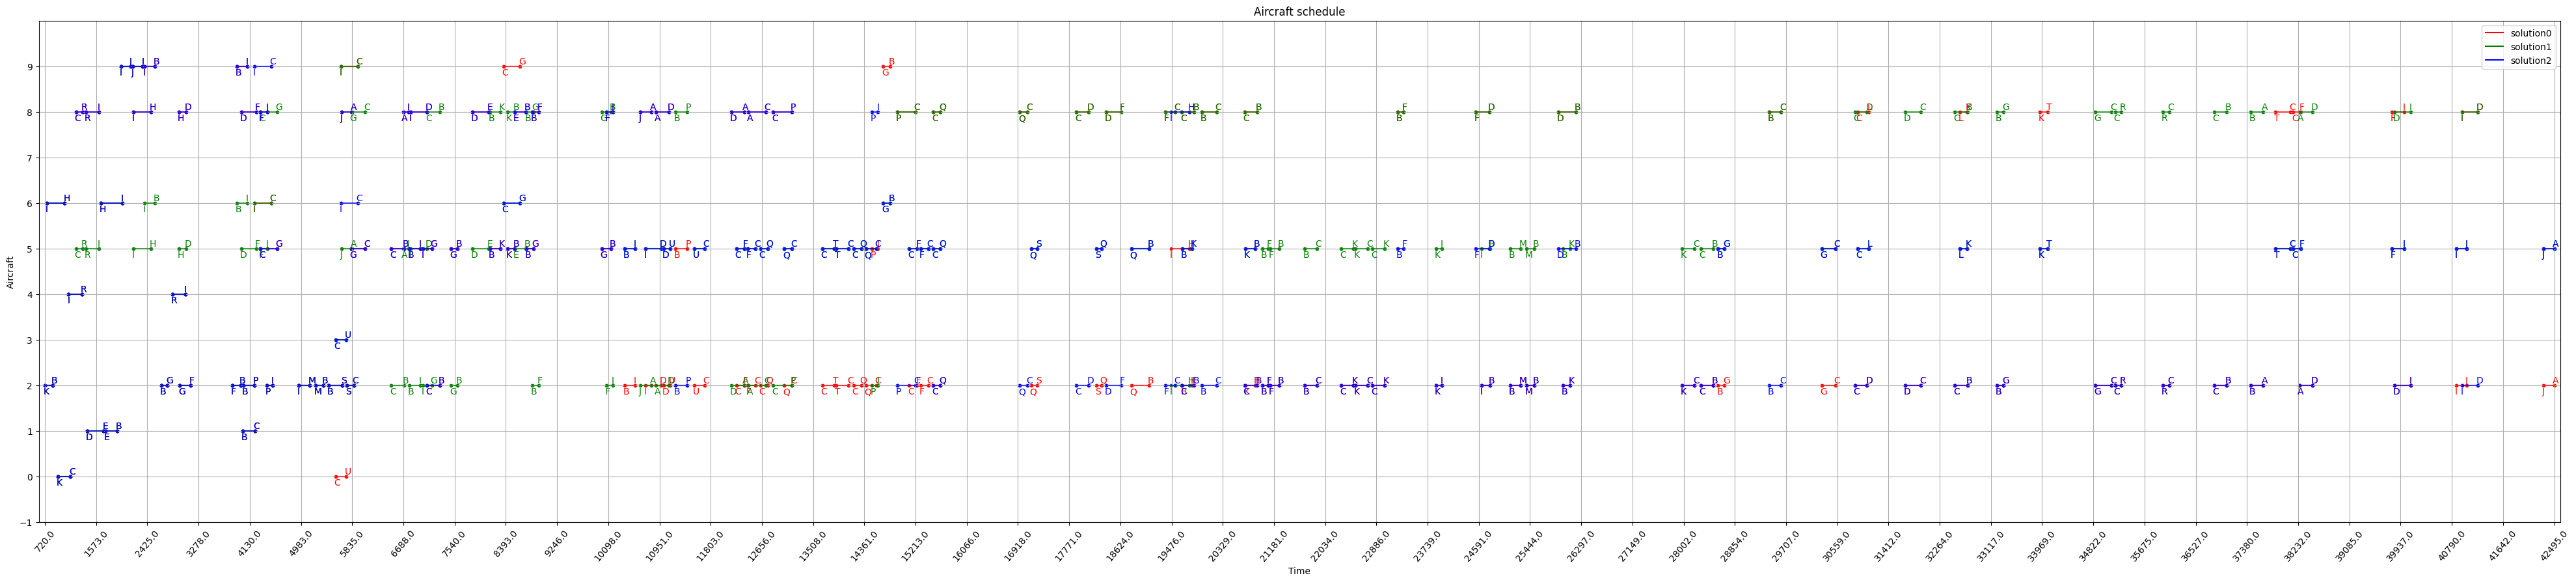

In [147]:
reporter = Reporter()
fig = reporter.plot_solution([found_solution, cplx_solution, interval_solution])